#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

# Install dependencies:

In [2]:
install_packages = True
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /home/budmil/anaconda3

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         121 KB
    openssl-1.1.1h             |       h7b6447c_0         2.5 MB
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  conda              conda-forge::conda-4.9.2-py38h578d9bd~ --> pkgs/main::conda-4.9.2-py38h06a4308_0
  openssl                                          anaconda --> pkgs/main



openssl-1.1.1h       | 2.5 MB    | ##################################### | 100% 
ca-certificates-2020 | 121 KB    | ############

In [3]:
!pip install html2text

# Imports

In [1]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [3]:
data_path = './videoinfo_CEii1_kEoZs_2020_12_01-23_08_31_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [4]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [5]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [6]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [7]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

/home/budmil/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 4956/4956 [00:02<00:00, 2171.82it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [8]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-12-01 14:44:34,Brent Kitter,Cringe .,0,Cringe .\n\n
1,2020-12-01 01:22:06,BEM BEM,So guy we all should have some sort of sense. dont you think it cost whosoever doing the spraying? Or whatever you may call it Marking up the sky like that. and look at it this way if it wasnt doing anything why do it? yea? and dont tell me it was always like that people are just noticing it now. becuase people been looking up for a long time now and its not like before. i cant spell it all out ok.,0,So guy we all should have some sort of sense. dont you think it cost whosoever\ndoing the spraying? Or whatever you may call it Marking up the sky like that.\nand look at it this way if it wasnt doing anything why do it? yea? and dont\ntell me it was always like that people are just noticing it now. becuase\npeople been looking up for a long time now and its not like before. i cant\nspell it all out ok.\n\n
2,2020-12-01 04:29:56,Elyjah Stark,“If it wasn’t doing anything why do it” ... do what? Exhaust water vapor? Because that’s the natural by product of combusting a hydrocarbon fuel. And that water vapor naturally condenses (flash freezes) when the air temperature is -40ish degrees or colder. And that condensation naturally is unable to sublimate when the relative humidity of the ambient air is high. No one is doing anything. It’s physics at work.,1,“If it wasn’t doing anything why do it” ... do what? Exhaust water vapor?\nBecause that’s the natural by product of combusting a hydrocarbon fuel. And\nthat water vapor naturally condenses (flash freezes) when the air temperature\nis -40ish degrees or colder. And that condensation naturally is unable to\nsublimate when the relative humidity of the ambient air is high. No one is\ndoing anything. It’s physics at work.\n\n
3,2020-12-01 01:55:13,siouxperb5570,"There is no ""spraying"". Persistent contrails have been a reality in the skies for more than 80 years. As the amount of air traffic has increased, so have the contrails. Besides, the 'chemtrail' hoax is mathematically impossible. If you think otherwise, simply name an aircraft that can carry the amount of payload that would equal the mass of a persistent contrail. There isn't one. Case closed.",1,"There is no ""spraying"". Persistent contrails have been a reality in the skies\nfor more than 80 years. As the amount of air traffic has increased, so have\nthe contrails. Besides, the 'chemtrail' hoax is mathematically impossible. If\nyou think otherwise, simply name an aircraft that can carry the amount of\npayload that would equal the mass of a persistent contrail. There isn't one.\nCase closed.\n\n"
4,2020-11-28 23:27:05,Anonymous Human,"If airline pilots are for some reason venting fuel a lot more often than they used to, this might account for an increase in long-persisting contrails over the last couple of decades.",0,"If airline pilots are for some reason venting fuel a lot more often than they\nused to, this might account for an increase in long-persisting contrails over\nthe last couple of decades.\n\n"


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [9]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [11]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 

ResourceExhaustedError:  OOM when allocating tensor with shape[200,8,841,841] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node StatefulPartitionedCall/StatefulPartitionedCall/EncoderTransformer/Transformer/SparseTransformerEncode/Layer_0/SelfAttention/SparseMultiheadAttention/DotProductAttention/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_restored_function_body_88309]

Function call stack:
restored_function_body


## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.         -0.02615304 -0.01595093 ...  0.03544068  0.11431973
   0.04244978]
 [-0.02615304  1.0000001   0.25287086 ...  0.19574177  0.05822545
   0.09644982]
 [-0.01595093  0.25287086  1.0000004  ...  0.12160502  0.03123004
   0.09430367]
 ...
 [ 0.03544068  0.19574177  0.12160502 ...  1.0000005   0.08829152
   0.14527209]
 [ 0.11431973  0.05822545  0.03123004 ...  0.08829152  1.0000001
   0.11541677]
 [ 0.04244978  0.09644982  0.09430367 ...  0.14527209  0.11541677
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

/home/budmil/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/budmil/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


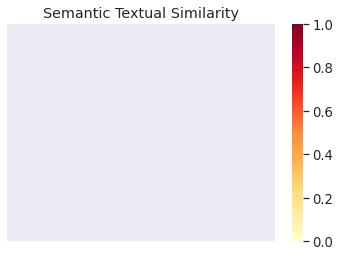

In [15]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 10000

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [18]:
comment_index = 122
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

you failed to mention what are they spraying. total lies a sellout is the
worse thing anybody can be. do a real research before you post nonsense.




Print similar comments.

In [19]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: you failed to mention what are they spraying. total lies a sellout is the
worse thing anybody can be. do a real research before you post nonsense.


Top similar comment 2: Doesnt matter what you think they are. They shouldn't be spraying stuff in the
air because we are breathing that crap and it's going into our eyes, on our
skin, the soil. Dont you see a problem with that you government issued douche
bag  
Of course they're doing other shady bs but this is by far the absolute worse
because everyone including the planet is being and will be effected by this.
Keep pretending the world is just great and theres nothing absolutely insane
or diabolical going on, that fine but you are in for a rude awakening


Top similar comment 3: @ so what are those planes spraying? Because you cant say nothing
is being sprayed


Top similar comment 4: @ Bottom line - they are spraying metals and crap in the air and
there IS evidence to support that. A lot of it... taken over years.